<a href="https://colab.research.google.com/github/Ab2207/Academic-Projects-Data-Analytics/blob/main/Masters%20Thesis%20Experiment%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Connecting Google Drive to Colab to access the dataset

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Importing necessary libraries for loading the data , reading the data, pre-processing the data and tensorflow libraries to build hybrid deep learning model

import pandas as pd
import numpy as np 
import string 
string.punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
import re
import unicodedata
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Activation, Input, Flatten, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Reading the data and storing it in the variable "data"

data = pd.read_csv("/content/gdrive/My Drive/BLM_Tweets_1M.csv")

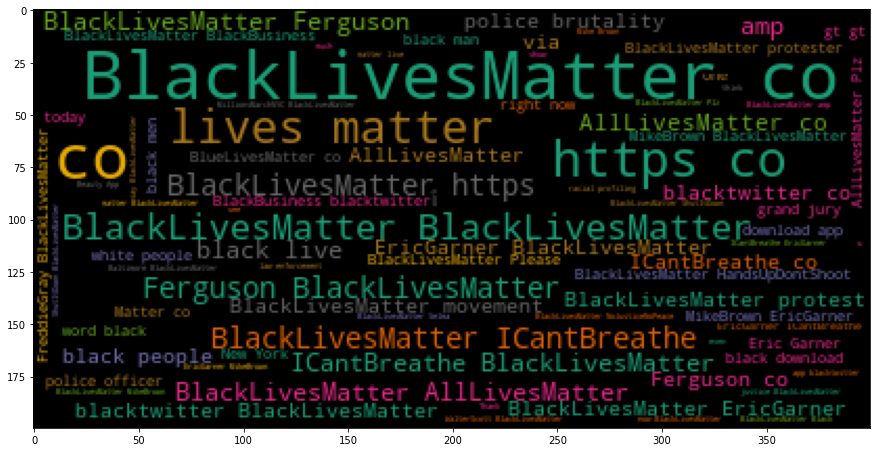

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sentences = data['text'].tolist()
joined_sentences = ''.join(sentences)

plt.figure(figsize = (15,15))
plt.imshow(WordCloud(colormap='Dark2').generate(joined_sentences) )

In [ ]:
#Function to carry out all the pre-processing steps 

def tweets_cleaning(text):
    lowercase = text.lower()
    punc_removal = [char for char in lowercase if char not in string.punctuation]
    punc_removal_joined = ''.join(punc_removal)
    url_removal = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', punc_removal_joined, flags=re.MULTILINE)
    emoji_removal = url_removal.encode('ascii', 'ignore').decode('ascii')
    stopwords_removal = [word for word in emoji_removal.split() if word not in stopwords.words('english')]
    return stopwords_removal

In [ ]:
#Applying the pre-processing function to tweet text

data['cleaned_text'] = data['text'].apply(tweets_cleaning).astype(str)

In [ ]:
#Importing and applying TextBlob to the pre-processed text to find the polarity score

from textblob import TextBlob
data['polarity'] = data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
# Setting a condition list if polarity score is less than 0 then the target should be '0' for negative.. If polarity sscore is greater than 0 then the target
# should be '1' for positive.. Combining the conditionList and choiceList to create a new column 'target' using Numpy library 

conditionList = [
                 data['polarity'] < 0,
                 data['polarity'] >= 0]
choiceList = ['0', '1']
data['target'] = np.select(conditionList, choiceList, default='no_label')

In [ ]:
#Initilizing Tokenizer and fitting it on the cleaned text

tokenizer = Tokenizer(oov_token = "<OOV>")
tokenizer.fit_on_texts(data['cleaned_text'].values)

#word indexing calculates the number of unique words in the corpus of current dataset and assigns a number to each word starting from 0 till the last word
word_index = tokenizer.word_index 

In [ ]:
#Calling the texts_to_sequences method from tokenizer and applying it to the pre-processed data.. This converts the words into an array of numbers 
#generated from word_index

train_sentence_tokenizing = tokenizer.texts_to_sequences(data['cleaned_text'].values)

#The sequences generated from above line of code is formatted into a length of 26.. Setting this as the X variable for deep learning model
X = pad_sequences(train_sentence_tokenizing, padding = "post", truncating = "post", maxlen= 26)

In [ ]:
#Setting the 'target' column as the y variable for deep learning model

y = pd.get_dummies(data['target']).values

In [ ]:
#Declaring required hyper parameters for a successful deep learning model

vocab_size = len(word_index) + 1
embed_dim = 200
output_nodes = 128
batch_size = 320
kernel_size = 3
loss = 'binary_crossentropy'
optimizer = 'adam'
test_size = 0.3
input_length = X.shape[1]
convActivation = 'relu'
denseActivation = 'softmax'
convPadding = 'valid'
padding = 'post'
maxlen = 26
epochs = 1
verbose = 1

In [ ]:
#Train and test split in 0.7 to 0.3 ratio respectively 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234, test_size = test_size, stratify = y)

In [ ]:
#Building a hybird deep learning model 

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=input_length))
model.add(Dropout(0.4))
model.add(Conv1D(output_nodes, kernel_size, padding=convPadding, activation=convActivation))
model.add(MaxPooling1D())
model.add(Conv1D(output_nodes, kernel_size, padding=convPadding, activation=convActivation))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(output_nodes)))
model.add(Flatten())
model.add(Dense(2, activation=denseActivation))

model.compile(loss = loss, optimizer=optimizer, metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 200)           184962000 
_________________________________________________________________
dropout (Dropout)            (None, 26, 200)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 128)           76928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               2

In [ ]:
#Fitting the model on training data 

model.fit(X_train, y_train, epochs = epochs, verbose = verbose, batch_size=batch_size)

2195/2195 [==============================] - 4456s 2s/step - loss: 0.1208 - accuracy: 0.9540


In [ ]:
#Assessing the model on test data and saving the results to 'predictions'

predictions = model.predict(X_test, verbose = verbose, batch_size = batch_size)

941/941 [==============================] - 55s 58ms/step


In [ ]:
model.save('/content/gdrive/My Drive/exp3.h5')

In [ ]:
from tensorflow.keras.models import load_model
hybrid_model = load_model("/content/gdrive/My Drive/exp3.h5")

In [ ]:
hybrid_model.predict(X_test, verbose = verbose, batch_size=batch_size)

941/941 [==============================] - 57s 59ms/step


array([[5.4024940e-07, 9.9999940e-01],
       [3.1727825e-09, 1.0000000e+00],
       [3.5559939e-08, 1.0000000e+00],
       ...,
       [9.9999964e-01, 3.3453776e-07],
       [9.9999964e-01, 4.0048931e-07],
       [4.8051056e-08, 1.0000000e+00]], dtype=float32)

In [ ]:
#Downloading the data to csv with target to plot on tableau

data.to_csv("/content/gdrive/My Drive/blacklivesmatter_sentiment.csv")

In [ ]:
rounded_predictions = np.argmax(predictions, axis=-1)
rounded_labels=np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=rounded_labels, y_pred=rounded_predictions)


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['0','1']

Confusion matrix, without normalization
[[ 55153    714]
 [  1267 243799]]


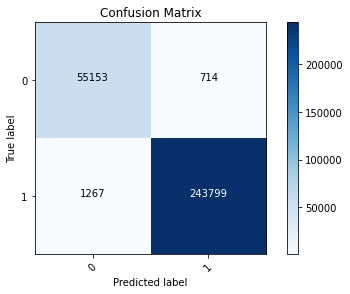

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 99.341714
